# ORIE 4580/5580/5581 Assignment 4

#### Students: Sean Benko (snb55)m, Sean Hansen (seh52)
#### References: ChatGPT

### Github link: [example Github link](https://github.com/snb55/Simulation-Projects)


### Instructions


* Due Friday September 29, at 11.59am on Gradescope.
* Assignment .ipynb files available for download on [Canvas](https://canvas.cornell.edu/courses/56826#:~:text=Assignments-,Assignments,-Assignments%20Module%20publish). Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Bard or ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**. You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.



### Suggested reading

Chapters 5 (sections 5.1, 5.2 and 5.3) and 6, as well as chapter 11 (to revise again what we discussed in class about confidence intervals) of [Simulation by Ross](https://catalog.library.cornell.edu/catalog/12745977).




---
---


# Question 1: Multivariate normals, and some finance (20 points)


Assume the following means and covariance matrix for the net annual returns (annual returns after accounting for inflation) on three investments:

$$\boldsymbol{\mu}=
\begin{bmatrix}
    \mu_{\text{U.S. stocks}}\\
    \mu_{\text{U.S. bonds}}\\
    \mu_{\text{EM bonds}}
\end{bmatrix}=
\begin{bmatrix}
    0.14 \\
    0.07 \\
    0.16\\
\end{bmatrix},$$

Moreover, we have $\sigma^2_{\text{U.S. stocks}}=0.0625, \sigma^2_{\text{U.S. bonds}}=0.01$ and $\sigma^2_{\text{EM bonds}}=0.09$. Assuming all three instruments are independent of each other, what is the probability that all three financial products simultaneously yield a positive return?



## Ans.

$$Z = (X-𝜇)/𝜎$$

$$ Z_{U.S. stocks} = (0-.14) ÷ \sqrt{.0625} = -0.56$$
$$ Z_{U.S. bonds} = (0-.07) ÷ \sqrt{.01} = -0.7$$
$$ Z_{E.M. bonds} = (0-.16) ÷ \sqrt{.09} = -0.533$$

$$P(Z_{U.S. stocks} > 0) = 0.7123$$
$$P(Z_{U.S. bonds} > 0) = 0.7580$$
$$P(Z_{E.M. bonds} > 0) = 0.7031$$

$$P(\text{All three financial products simultaneously yield a positive return}) =$$
$$P(Z_{U.S. stocks} > 0)*P(Z_{U.S. bonds} > 0)*P(Z_{E.M. bonds} > 0) = $$
$$0.7123 * 0.7580 * 0.7031 = $$
$$0.3796$$


___

**(b)** Next, assume that the assets are not independent, but rather, have covariance matrix
$$\boldsymbol{\Sigma}=
\begin{bmatrix}
    0.0625 & -0.01 & 0.0375 \\
    -0.01 & 0.01 & -0.015 \\
    0.0375 & -0.015 & 0.09
\end{bmatrix}.$$

Using simulation, estimate the probability that all three financial products simultaneously yield a positive return.
For the purposes of this problem, you are **not allowed** to use the Python function ${\tt numpy.random.multivariate\_normal}$, but rather, should generate *independent* normal rvs, and then apply the method(s) discussed in class.
In particular, you can compute the Cholesky decomposition of the covariance matrix using the Python function ${\tt scipy.linalg.cholesky(sigma, lower=True)}$.
___

## Ans.



In [1]:
import numpy as np

means = np.array([0.14, 0.07, 0.16])
cov_matrix = np.array([[0.0625, -0.01, 0.0375],
                       [-0.01, 0.01, -0.015],
                       [0.0375, -0.015, 0.09]])
cholesky_matrix = np.linalg.cholesky(cov_matrix)
k = 20
pilot_results = []

for _ in range(k):
    standard_normal_sample = np.random.randn(3)
    sample = means + np.dot(cholesky_matrix, standard_normal_sample)
    if all(sample > 0):
        pilot_results.append(1)
    else:
        pilot_results.append(0)

pilot_estimate = np.mean(pilot_results)
pilot_variance = np.var(pilot_results)

confidence_level = 0.95
margin_error = 0.01
required_sample_size = int(np.ceil((1.96**2 * pilot_variance) / (margin_error**2)))
N = required_sample_size
positive_count_production = 0
for _ in range(N):
    standard_normal_sample = np.random.randn(3)
    sample = means + np.dot(cholesky_matrix, standard_normal_sample)
    if all(sample > 0):
        positive_count_production += 1

final_estimate = positive_count_production / N
standard_error = np.sqrt(final_estimate * (1 - final_estimate) / N)
z_score = 1.96  # for a 95% confidence interval
margin = z_score * standard_error
confidence_interval = (final_estimate - margin, final_estimate + margin)

print(f"Final Estimated Probability: {final_estimate:.4f}")
print(f"Final Confidence Interval: ({confidence_interval[0]:.4f}, {confidence_interval[1]:.4f})")


Final Estimated Probability: 0.3711
Final Confidence Interval: (0.3614, 0.3808)


___
___

# Question 2: Covariance and copulas (30 points)

In general (i.e., apart from multivariate normals), *there is no closed form formula for generating rvs with given marginals and given covariance matrix*. However, a popular heuristic is the so-called *Gaussian copula trick*, which is widely used in finance. In this question, we will try and get a sense of how we can generate correlated uniforms, and how the Gaussian copula trick works.

___

**(a)** We will first try and make a method for generating two correlated uniform random variables $V_1$, $V_2$ with mean $\mathbb{E}[V_1]=\mathbb{E}[V_2]=0$, variance $Var(V_1)=Var(V_2)=1$, and covariance $Cov( V_1, V_2 ) = \sigma_{12}$ (for some given $\sigma_{12}\geq 0$).

For what $\alpha,\beta\in\mathbb{R}$ does a uniform distribution on $[\alpha,\beta]$ have mean $0$ and variance $1$.
___


## Ans.

$$\text{Set (α + β) ÷ 2 = 0 to satisfy the mean condition}$$
$$ \text{Set (β - α) = } \sqrt{12} \text{ to satisfy the variance condition}$$
$$β = -α$$
$$(β - α) = \sqrt{12}$$

$$(-α - α) = \sqrt{12}$$
$$-2*α = \sqrt{12}$$

$$α = \sqrt{12} ÷ -2 = -\sqrt{3}$$
$$β = \sqrt{3}$$

$$ \text{To have a uniform distribution on the interval [α, β] with mean 0 and variance 1}$$
$$ α = - \sqrt{3}$$
$$ β = \sqrt{3}$$

___

**(b)** Next, generate rvs $X_1,X_2\sim Uniform[\alpha, \beta]$ i.i.d (with $\alpha,\beta$ from previous part), and also sample $B\sim Bernoulli(p)$. Define:
\begin{align*}
	V_1 = X_1 \qquad,\qquad
	V_2 = (1-B)X_1+BX_2 = \begin{cases} X_1 & \text{ if $B = 0$} \\ X_2 & \text{ if $B = 1$} \end{cases}
	\end{align*}

What is $\mathbb{E}[V_2]$ and $Var(V_2)$?
___

## Ans.

$$𝔼:$$
$$𝔼[V_2] = 𝔼[(1-B)*X_1 + B*X_2]$$
$$𝔼[V_2] = 𝔼[1-B]*𝔼[X_1] + 𝔼[B]*𝔼[X_2]$$
$$𝔼[V_2] = 𝔼[1-B]*0 + 𝔼[B]*0$$
$$=0$$

$$\text{Var}:$$
$$\text{Var}(V_2) = 𝔼[V_2^2]-𝔼[V_2]^2$$
$$\text{Var}(V_2) = 𝔼[V_2^2]-0$$
$$𝔼[V_2^2]=P(B=0)*𝔼[V_2^2||B=0] + P(B=1)*𝔼[V_2^2||B=1]$$
$$𝔼[V_2^2]=(1-p)*𝔼[X_1^2] + p*𝔼[X_2^2]$$
$$𝔼[V_2^2]=(1-p)*𝔼[X_1^2] + p*𝔼[X_2^2]$$
$$𝔼[V_2^2]=(1-p)*(1) + p*(1)$$
$$𝔼[V_2^2]=1-p + p$$
$$ = 1$$

$$\text{Answers}:$$
$$𝔼[V_2] =0$$
$$\text{Var}(V_2) = 1$$

___
**(c)** For what value of $p$ do we get $Cov(V_1, V_2 )=\sigma_{12}$ (for $\sigma_{12}\geq 0$)?
___

## Ans.
$$\text{Cov}(V_1,V_2)= \sigma_{12} \text{ for } \sigma_{12}>0 $$
$$\text{Cov}(V_1,V_2)= 𝔼[V_1*V_2]-𝔼[V_1]*𝔼[V_2]$$
$$\text{Cov}(V_1,V_2)=𝔼[V_1*V_2]-𝔼[V_1]*0$$
$$\text{Cov}(V_1,V_2)=𝔼[V_1*V_2]$$
$$\text{Cov}(V_1,V_2)=P(B=0)*𝔼[X_1^2] + P(B=1)*𝔼[X_1*X_2]$$
$$\text{Cov}(V_1,V_2)=(1-p)*(1) + p*0$$
$$\text{Cov}(V_1,V_2)=1-p$$
$$p = 1-\sigma_{12}$$

___

**(d)** Create a function to generate two correlated uniform random variables $V_1$, $V_2$ such that $\mathbb{E}[V_1]=\mathbb{E}[V_2]=0,Var(V_1)=Var(V_2)=1$ and $Cov( U_1, U_2 ) = \sigma_{12}$. Use this to show a scatter plot of $(V_1,V_2)$ for correlation values $\sigma_{12}=0,0.25,0.5,0.75$ and $1$.

___

## Ans.

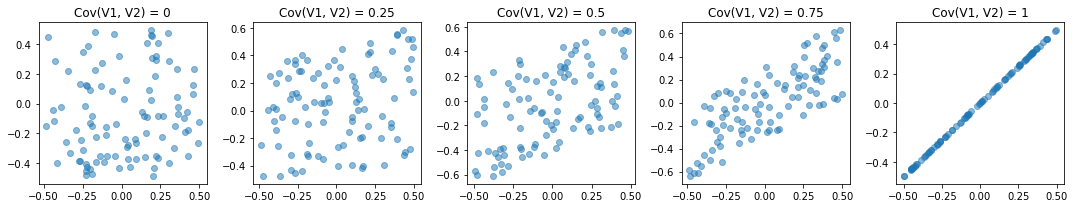

In [2]:
import matplotlib.pyplot as plt

def gen(sigma12, num_samples):
    U1 = np.random.rand(num_samples) - 0.5
    U2 = np.random.rand(num_samples) - 0.5
    V1 = U1
    V2 = sigma12 * U1 + np.sqrt(1 - sigma12**2) * U2

    return V1, V2

correlation_values = [0, 0.25, 0.5, 0.75, 1]

num_samples = 100

fig, axes = plt.subplots(1, len(correlation_values), figsize=(15, 3))

for i, sigma12 in enumerate(correlation_values):
    V1, V2 = gen(sigma12, num_samples)

    axes[i].scatter(V1, V2, alpha=0.5)
    axes[i].set_title(f'Cov(V1, V2) = {sigma12}')

plt.tight_layout()
plt.show()


___

**(e)** Using the above function, compute $\mathbb{P}[V_1\leq 0,V_2\leq 0]$ for the case when $\sigma_{12}=0.5$ (in a financial application, this can correspond to *both* $V_1$ and $V_2$ 'defaulting').
___

## Ans.

In [3]:
sigma12 = 0.5
num_samples = 1000

V1, V2 = gen(sigma12, num_samples)

probability_both_negative = np.mean((V1 <= 0) & (V2 <= 0))

print(f'P(V1 <= 0, V2 <= 0) when sigma12 = {sigma12}: {probability_both_negative}')


P(V1 <= 0, V2 <= 0) when sigma12 = 0.5: 0.302


___

**(f)** The Gaussian copula trick is based on first generating a multivariate normal vector with given covariance matrix $\Sigma$, and then using inversion to convert it to a vector of uniform rvs, which can then used to generate the desired rvs. We now demonstrate this in the above setting.

Let $\phi(\cdot)$ denote the 1-d normal cdf. Generate $(Z_1,Z_2)$ as multivariate normals with covariance
$\Sigma =\begin{pmatrix}
		1 & 0.5 \\
		0.5 & 1
	\end{pmatrix}$,
and define $W_1 = \alpha + (\beta-\alpha)\phi(Z_1)$ and $W_2 = \alpha + (\beta-\alpha)\phi(Z_2)$.

Argue $W_1$, $W_2$ are uniform on $[\alpha,\beta]$ (and hence $\mathbb{E}[W_1]=\mathbb{E}[W_2]=0,Var(W_1)=Var(W_2)=1$). Next, for $\sigma_{12}=0.5$ and $\alpha,\beta$ as above, write a function to generate $W_1,W_2$ as described, and use these to plot the scatter plot, and compute $\mathbb{P}[W_1\geq 0,W_2\geq 0]$.

___

## Ans.


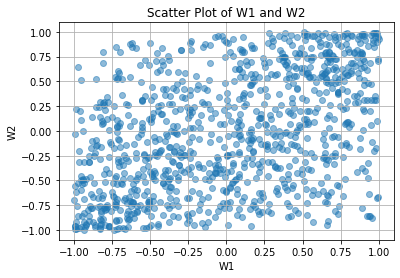

P(W1 >= 0, W2 >= 0): 0.324


In [5]:
from scipy.stats import norm

Sigma = np.array([[1, 0.5],
                  [0.5, 1]])
alpha = -1
beta = 1
num_samples = 1000
mean = np.array([0, 0])
Z1, Z2 = np.random.multivariate_normal(mean, Sigma, num_samples).T

W1 = alpha + (beta - alpha) * norm.cdf(Z1)
W2 = alpha + (beta - alpha) * norm.cdf(Z2)

plt.scatter(W1, W2, alpha=0.5)
plt.xlabel('W1')
plt.ylabel('W2')
plt.title('Scatter Plot of W1 and W2')
plt.grid(True)
plt.show()

probability_both_positive = np.mean((W1 >= 0) & (W2 >= 0))

print(f'P(W1 >= 0, W2 >= 0): {probability_both_positive}')


___
___

# Question 3: Generating random samples in some given set (20 pts)

___

**(a)** We want to sample points which are uniformly distributed in the set  $\mathcal{S} = \{(x,y)| x\in \mathbb{R}, y \in [0,e^{-x^2/2}]\}$ (i.e., between the lines $y=0$ and $y=e^{-x^2/2}$). Generate 1000 independent samples $(X_i,Y_i)$, and plot them using a scatterplot, along with the lines $y=0$ and $y=e^{-x^2/2}$.

(Hint: Try to 'reverse' what we do in Acceptance-Rejection).
___

To do the reverse of the Acceptance Rejection method, instead of generating samples from a know distribution and accepting them or rejecting them based on comparison with the target distribution, we will generate samples in the bounding rectangle and accept them if they fall within S. We can do this by:

## Ans.

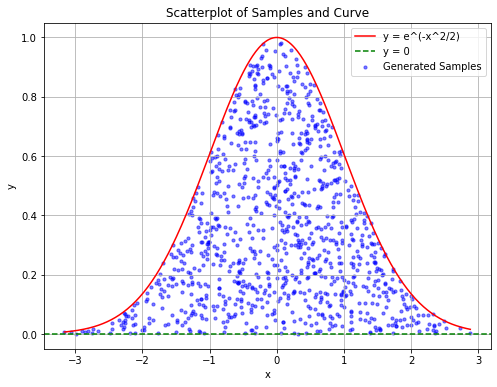

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Set the number of samples
num_samples = 1000
samples = []

# Generate samples
while len(samples) < num_samples:
    x = np.random.normal() # We use the Gaussian to sample x in the set of all real numbers
    y = np.random.uniform(0, np.exp(-x**2 / 2))
    if y <= np.exp(-x**2 / 2):
        samples.append((x, y))

# Extract x and y coordinates from the samples
x_coordinates, y_coordinates = zip(*samples)

# Plot the scatterplot of the samples
plt.figure(figsize=(8, 6))
plt.scatter(x_coordinates, y_coordinates, s=10, c='b', marker='o', alpha=0.5, label='Generated Samples')

# Generate x values for the curve y = e^(-x^2/2)
x_values = np.linspace(min(x_coordinates), max(x_coordinates), 400)
y_values = np.exp(-x_values**2 / 2)

# Plot the curve y = e^(-x^2/2)
plt.plot(x_values, y_values, 'r', label='y = e^(-x^2/2)')

# Plot the line y = 0
plt.axhline(0, color='g', linestyle='--', label='y = 0')

# Set axis labels, title, legend, and grid
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatterplot of Samples and Curve')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


___
**(b)** Next, suppose we want to sample points which are uniformly distributed on the set $\{(x,y)\in\mathbb{R}^2|x^2+y^2 = 1\}$ (i.e., on the *circumference* of the unit circle). One way to do so may be to generate points $(U_i,V_i)$ uniformly in $[-1,1]^2$ (like in the first homework), and then *project* them to the circle, i.e., take $(X_i,Y_i) = \left(\frac{U_i}{\sqrt{U_i^2+V_i^2}},\frac{V_i}{\sqrt{U_i^2+V_i^2}}\right)$. Generate $1000$ points in this way, and plot them using a scatter plot.

Are these uniformly distributed on the circumference of the circle? Try checking the histogram of their angles (i.e., the histogram of $\theta_i = \tan^{-1}(Y_i/X_i)$).
___

## Ans.

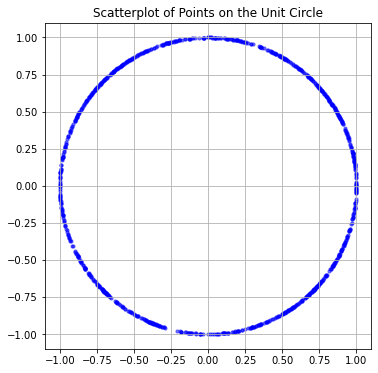

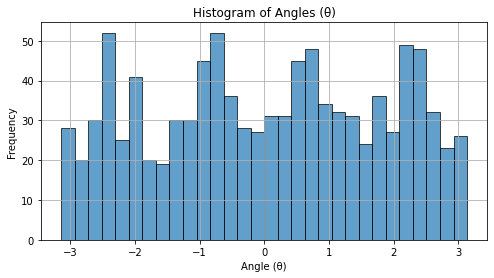

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Set the number of points
num_points = 1000

# Generate random points (U, V) uniformly in [-1, 1]^2
U = np.random.uniform(-1, 1, num_points)
V = np.random.uniform(-1, 1, num_points)

# Project points onto the unit circle
X = U / np.sqrt(U**2 + V**2)
Y = V / np.sqrt(U**2 + V**2)

# Calculate angles (theta)
theta = np.arctan2(Y, X)

# Plot the points on the unit circle
plt.figure(figsize=(6, 6))
plt.scatter(X, Y, s=10, c='b', marker='o', alpha=0.5, label='Generated Points')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Scatterplot of Points on the Unit Circle')
plt.grid(True)

# Plot the histogram of angles (theta)
plt.figure(figsize=(8, 4))
plt.hist(theta, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Angle (θ)')
plt.ylabel('Frequency')
plt.title('Histogram of Angles (θ)')
plt.grid(True)

plt.show()


We can see that these points are not uniformly distributed. The distribution looks similar to 4 gaussians in a series.



---

**(c)** Next, generate points $(Z_i,W_i)$ as independent standard normals (i.e., $(Z_i,W_i)\sim \mathcal{N}(0,I_2)$, and again project them to the circle, i.e., take $(X_i,Y_i) = \left(\frac{Z_i}{\sqrt{Z_i^2+W_i^2}},\frac{W_i}{\sqrt{Z_i^2+W_i^2}}\right)$. Generate $1000$ points in this way, and plot them using a scatter plot.

Are these uniformly distributed on the circumference of the circle? Again, check the histogram of their angles $\theta_i$. Can you explain the difference between parts (b) and (c)?

___

## Ans.

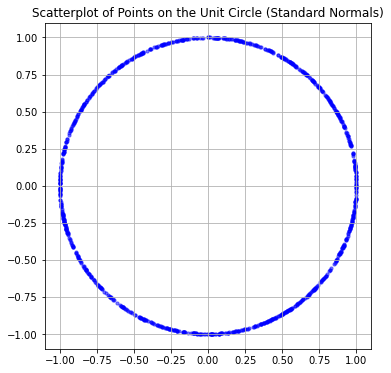

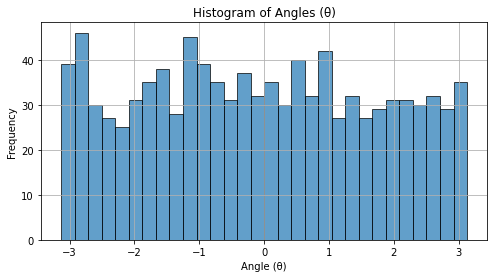

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Set the number of points
num_points = 1000

# Generate random standard normal variables Z and W
Z = np.random.normal(0, 1, num_points)
W = np.random.normal(0, 1, num_points)

# Project points onto the unit circle
X = Z / np.sqrt(Z**2 + W**2)
Y = W / np.sqrt(Z**2 + W**2)

# Calculate angles (theta)
theta = np.arctan2(Y, X)

# Plot the points on the unit circle
plt.figure(figsize=(6, 6))
plt.scatter(X, Y, s=10, c='b', marker='o', alpha=0.5, label='Generated Points')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Scatterplot of Points on the Unit Circle (Standard Normals)')
plt.grid(True)

# Plot the histogram of angles (theta)
plt.figure(figsize=(8, 4))
plt.hist(theta, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Angle (θ)')
plt.ylabel('Frequency')
plt.title('Histogram of Angles (θ)')
plt.grid(True)

plt.show()


We can see that these angles are more uniformly distributed than in part b. Of course it is not perfect, but this is a result of generating only 1000 samples.

Difference between Parts (b) and (c):

The main difference between parts (b) and (c) lies in the method of generating the points. In part (b), I generated points uniformly in a square and then projected them, while in part (c), you directly generated points as standard normals and projected them.

The non-uniformity in Part (b) arises from the bias introduced during the projection of points from a square to a circle. In contrast, Part (c) generates points using standard normals, resulting in a more uniform distribution when projected onto the circle.






___
___

# Question 4: The Inspection paradox (30 pts)

Have you ever felt like you wait too long for elevators, taxis, buses, etc.? Guess what - you may be right!

We are going to simulate a number of train and passenger arrivals at a station, and try to measure the time each passenger needs to wait for a train. To do this, first generate a stream of 10,000 train passengers, each of whom have an independent arrival time which is uniformly distributed over an interval of 1,000 minutes (i.e., passenger $i$ arrives at time $T_i\sim [0,1,000]$. Sort the passengers by arrival time, and use this resulting vector for all subsequent parts.

In [43]:
import numpy as np
import scipy.stats as stats

# Step 1: Generate passenger arrival times
passenger_arrival_times = np.random.uniform(0, 1000, 10000)

# Step 2: Sort passengers by arrival time
passenger_arrival_times.sort()

___

**(a)** Suppose trains arrive at the station deterministically every 10 minutes. Assume each train has infinite capacity, so that everyone waiting at the station when a train arrives can get on; also assume that passengers get on the train instantaneously. Estimate the expected time (with CIs) that any *randomly chosen* passenger spends waiting at the station for the next train.
___


## Ans.

In [44]:
# Calculate waiting times
train_arrival_interval = 10  # Trains arrive every 10 minutes
waiting_times = []

for i in range(len(passenger_arrival_times)):
    next_train_arrival = ((passenger_arrival_times[i] // train_arrival_interval) + 1) * train_arrival_interval
    waiting_time = next_train_arrival - passenger_arrival_times[i]
    waiting_times.append(waiting_time)

# Calculate average waiting time and confidence intervals
average_waiting_time = np.mean(waiting_times)

# Calculate 95% confidence intervals
confidence_interval = stats.norm.interval(0.95, loc=average_waiting_time, 
                                          scale=stats.sem(waiting_times))

# Print the results
print(f"Estimated Average Waiting Time: {average_waiting_time:.2f} minutes")
print(f"95% Confidence Intervals: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}) minutes")


Estimated Average Waiting Time: 5.03 minutes
95% Confidence Intervals: (4.98, 5.09) minutes


___
**(b)** Next, assume trains arrive at the station with *inter-arrival* time (i.e., time between two trains) distributed according to an exponential distribution with mean 10 minutes. Again, use your vector of passenger arrival times to estimate the expected waiting time for a randomly chosen passenger.
___


## Ans.

In [92]:
import numpy as np
import scipy.stats as stats

# Step 3: Simulate train arrivals using exponential distribution with mean 10 minutes
mean_interarrival_time = 10  # Mean inter-arrival time for trains
train_arrival_times = np.cumsum(np.random.exponential(scale=mean_interarrival_time, size=10000))

# Step 4: Calculate waiting times for each passenger using a vectorized approach
closest_train_arrivals = np.searchsorted(train_arrival_times, passenger_arrival_times)
waiting_times = train_arrival_times[closest_train_arrivals] - passenger_arrival_times

# Step 5: Calculate average waiting time
average_waiting_time = np.mean(waiting_times)

# Step 6: Calculate 95% confidence interval
confidence_interval = stats.t.interval(0.95, len(waiting_times) - 1, loc=np.mean(waiting_times), scale=stats.sem(waiting_times))

# Print the result
print(f"Estimated Average Waiting Time: {average_waiting_time:.2f} minutes")
print(f"95% Confidence Interval: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}) minutes")


Estimated Average Waiting Time: 10.05 minutes
95% Confidence Interval: (9.84, 10.26) minutes


___

**(c)** (Hopefully, you found the answer in part (b) to be different, and surprisingly so, compared to part (a).)

The train service claims that there is a train every $10$ minutes on average. In part (a), this is clearly the case, but is it so in part (b) as well? To understand this, use your data from part (b) to compute an empirical estimate with CIs for the inter-arrival times between trains.

___

In [24]:
import numpy as np
import scipy.stats as stats

# Set random seed for reproducibility
np.random.seed(1)

# Generate train arrival times as in part (b)
mean_interarrival_time = 10  # Mean inter-arrival time for trains
train_arrival_times = np.cumsum(np.random.exponential(mean_interarrival_time, 10000))

# Step 1: Calculate actual inter-arrival times between trains
interarrival_times = np.diff(train_arrival_times)

# Step 2: Calculate mean and standard deviation of empirical inter-arrival times
mean_interarrival = np.mean(interarrival_times)
std_interarrival = np.std(interarrival_times, ddof=1)  # ddof=1 for sample standard deviation

# Step 3: Compute 95% confidence intervals for the mean inter-arrival time
n = len(interarrival_times)
confidence_interval = stats.t.interval(0.95, df=n-1, loc=mean_interarrival, scale=std_interarrival/np.sqrt(n))

# Print the results
print(f"Mean Inter-Arrival Time: {mean_interarrival:.2f} minutes")
print(f"Standard Deviation of Inter-Arrival Times: {std_interarrival:.2f} minutes")
print(f"95% Confidence Intervals for Mean Inter-Arrival Time: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}) minutes")


Mean Inter-Arrival Time: 9.78 minutes
Standard Deviation of Inter-Arrival Times: 9.74 minutes
95% Confidence Intervals for Mean Inter-Arrival Time: (9.58, 9.97) minutes


___

**(d)** To understand what may be happening between parts (a) and (b), use the data from the simulations in parts (a) and (b) to estimate the average inter-arrival time between trains that each passenger experiences in each case. In other words, if passenger $i$ gets on train number $n$, thn we want to define his inter-arrival time $I_i$ to be the difference $A_n~-~A_{n-1}$ where $A_n$ is the arrival time of train $n$.

Compute the sample mean and CI of the interval $I_i$ for a randomly chosen passenger $i$ in each of the two settings. How are these related to the waiting time estimates you got in each part? Can you explain this?

___

For part a) the train is guarenteed to arrive every 10 minutes, thus the sample mean would be 0 and the confidence interval would be (10,10) with 100% confidence. This is defined in the problem.

When a passenger arrives, they come in the interval where the difference between the next arrival time and last arival time is 10 minutes.


In [123]:
#For Part b) we compute
inter_arrival_times_b = np.diff(np.concatenate(([0], train_arrival_times_b)))

mean_inter_arrival_b = np.mean(inter_arrival_times_b)
ci_inter_arrival_b = stats.t.interval(0.95, len(inter_arrival_times_b) - 1, loc=np.mean(inter_arrival_times_b), scale=stats.sem(inter_arrival_times_b))

print("\nSetting (b) - Average Inter-Arrival Time:")
print(f"Mean: {mean_inter_arrival_b:.2f} minutes")
print(f"95% Confidence Interval: ({ci_inter_arrival_b[0]:.2f}, {ci_inter_arrival_b[1]:.2f}) minutes")



Setting (b) - Average Inter-Arrival Time:
Mean: 9.88 minutes
95% Confidence Interval: (9.69, 10.08) minutes


Now, let's analyze the results and their relation to the waiting time estimates:

In part (b), where train arrivals follow an exponential distribution with a mean of 10 minutes, the sample mean inter-arrival time (𝐼𝑖) may deviate from 10 minutes due to the randomness introduced by the exponential distribution. The sample mean in this case will still be influenced by the exponential distribution's variability.

The relationship to waiting time estimates:

The waiting time estimates in part (a) are  determined by the deterministic train arrivals and are equal to the time passengers spend waiting for the next train.

In part (b), the waiting time estimates are influenced by both the inter-arrival times and the passenger arrival times. Passengers who arrive close to the time of a train's arrival will have shorter waiting times, but the variability in the inter-arrival times also affects these estimates.


**(e) (Optional for all students)** Based on your previous parts, can you come up with an explanation for what is going on?  